## Abstract

##### Cubesats are becoming more popular by the day, as they provide an affordable way for universities and small companies to access space. Nevertheless, that also means that substantial amounts of new orbital objects are being launched to LEO every year. The goal of the analysis is to find whether most cubesats fly in similar orbits, and to find out which areas of LEO have a higher occupation of this kind of satellite. The used data is obtained from Celestrak and analyzed using Python.

The necessary libraries are imported

In [61]:
import urllib

import numpy as np
from matplotlib import pyplot as plt

from tletools import TLE

from astropy import units as u
from poliastro.bodies import Earth, Sun
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter3D

import plotly.io as pio

In [62]:
pio.renderers.default = 'plotly_mimetype+notebook_connected'

The following function removes all blanck spaces from the end of the string that it receives

In [63]:
def remSpace(str):
    if str[-1] == ' ':
        return remSpace(str[:-1])
    else:
        return str

The text file with the TLE data is imported from the Celestrak website, as to always have the latest data

Then, the text is transformed into a string array, removing the new line command and any blank space at the end of each string.

Finally, the cubesats information is loaded into the *cubesats* TLE object array

In [64]:
Cubesats_URL = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=cubesat&FORMAT=tle'
tle_text = urllib.request.urlopen(Cubesats_URL)
#tle_text = open('Data/Cubesats.txt')
tle_str = [remSpace(line.decode('UTF-8').replace('\n', '')) for line in tle_text]

cubesats = [TLE.from_lines(tle_str[i], tle_str[i + 1], tle_str[i + 2]) for i in range(0, len(tle_str), 3)]

The cubesats semi-major axis, inclinations and eccentricity are loaded into the *smas*, *incs* and *eccs* arrays, and their value distribution is plotted into histograms

The average value of each one, plus the maximum value of the eccentricity is printed

The semi-major axis average and standard deviation are: 6899.09 km and 108.91 km
The inclinations average and standard deviation are: 86.85º and 21.26º
The eccentricities average and standard deviation are: 0.00395 and 0.00916
The highest eccentricity is 0.06742


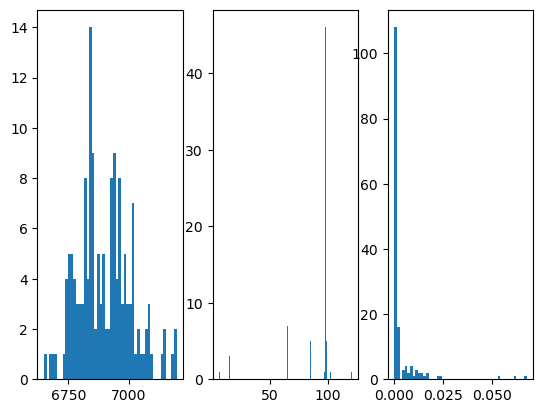

In [65]:
smas = [i.a for i in cubesats]
incs = [i.inc for i in cubesats]
eccs = [i.ecc for i in cubesats]

fig1, ax1 = plt.subplots(1, 3)

ax1[0].hist(smas, bins = 50)
ax1[1].hist(incs, bins = 250)
ax1[2].hist(eccs, bins = 50)

print('The semi-major axis average and standard deviation are: {} km and {} km'.format(round(np.mean(smas), 2), round(np.std(smas), 2)))
print('The inclinations average and standard deviation are: {}º and {}º'.format(round(np.mean(incs), 2), round(np.std(incs), 2)))
print('The eccentricities average and standard deviation are: {} and {}'.format(round(np.mean(eccs), 5), round(np.std(eccs), 5)))
print('The highest eccentricity is {}'.format(round(np.max(eccs), 5)))

The maximum and minimum heights above the earth are visualized to see whether the cubesats are in LEO

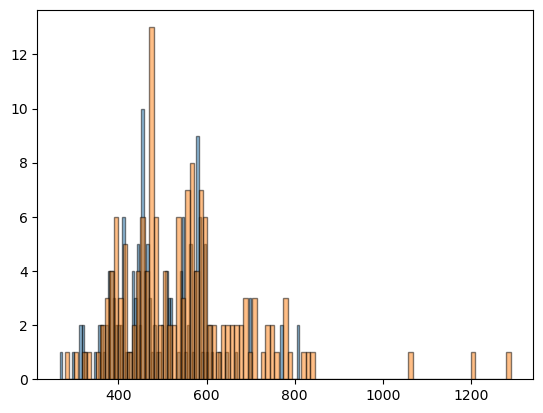

In [76]:
hmins = [(sat.a * (1 - sat.ecc)) - 6378 for sat in cubesats]
hmaxs = [(sat.a * (1 + sat.ecc)) - 6378 for sat in cubesats]

_ = plt.hist(hmins, bins = 100, edgecolor = 'k', alpha = 0.5)
_ = plt.hist(hmaxs, bins = 100, edgecolor = 'k', alpha = 0.5)

The orbits are checked for whether they are sun-synchronous

For that to be the case, the temporal variation of the Right-Angle Ascension Node (RAAN) should be of $360 \degree $ per year, $1.1408 \times 10^{-5} \frac{\degree }{s}$ or $1.991 \times 10^{-7} \frac{\degree }{s}$

The temporal increment in RAAN for an earth-orbiting body is the following, considering only the perturbation due to the $J_{2}$ term;

\begin{gather}
\frac{d \Omega}{dt} \approx - \frac{3J_{2}R_{E}^{2}\sqrt{\mu }cos(i)}{2a^{\frac{7}{2}}}
\end{gather}

Where:

- $R_{E}$ is radius of the earth
- $\mu $ is the gravitational parameter of the earth
- $J_{2}$ is the coefficient for the second zonal term due to the earth's oblateness
- $a$ is the semi-major axis of the orbit

The cubesat are assesed by checking if their orbit RAAN variation is within $2 \% $ of the nominal SSO value


The approximate number of cubesats that are in SSO is 52, accounting for 33.99% of the total


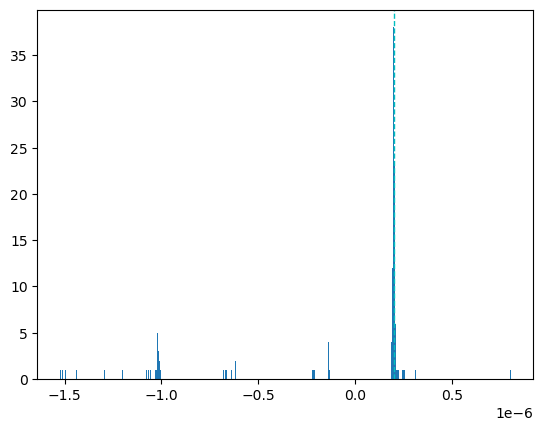

In [105]:
dRAANs = []

ref_SSO = (2 * np.pi) / (365.24 * 24 * 3600)

for sat in cubesats:
    dRAANs.append((-3 * 1.08263e-3 * (6378e3 ** 2) * np.cos(sat.inc * (np.pi / 180)) * np.sqrt(3.986004e14)) / (2 * ((sat.a * 1000) ** (7 /2))))


plt.hist(dRAANs, bins = 500)
plt.axvline(ref_SSO, 0, 50, color = 'c', linestyle = 'dashed', linewidth = 1)

sats_SSO = [((i > (ref_SSO * 0.98)) and (i < (ref_SSO * 1.02))) for i in dRAANs]
count_SSO = np.count_nonzero(sats_SSO)
print('The approximate number of cubesats that are in SSO is {}, accounting for {}% of the total'.format(count_SSO, round((count_SSO / len(dRAANs) * 100), 2)))



##### To get a better intuition of the orbit distribution, all of them are plotted together in an interactive 3D graph

In [68]:
'''orbits = [sat.to_orbit() for sat in cubesats]

frame = OrbitPlotter3D()

for orbit in orbits[:-1]:
    frame.plot(orbit)

frame.plot(orbits[-1])'''

'orbits = [sat.to_orbit() for sat in cubesats]\n\nframe = OrbitPlotter3D()\n\nfor orbit in orbits[:-1]:\n    frame.plot(orbit)\n\nframe.plot(orbits[-1])'